<a href="https://www.kaggle.com/code/lorresprz/covid19-tweet-analysis-rnn-lstm-others?scriptVersionId=148049353" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [22]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/covid19-tweets/covid19_tweets.csv
/kaggle/input/glove-twitter/glove.twitter.27B.200d.txt
/kaggle/input/glove-twitter/glove.twitter.27B.25d.txt
/kaggle/input/glove-twitter/glove.twitter.27B.50d.txt
/kaggle/input/glove-twitter/glove.twitter.27B.100d.txt
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv


In this notebook, we will work on the dataset of Covid19 tweets to classify the tweets into 3 possible categories: Negative, Neutral and Positive. In the first part of the notebook, a simple general model is defined as a function that can be customized to take as input one of the 3 types of recurrent layers: RNN, GRU and LSTM. In the second part of the notebook, we add an embedding layer that uses the pretrained GloVe embedding and define another general function with 3 possible inputs: RNN, GRU and LSTM. 

In [4]:
df_train = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding = 'latin')
df_test = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv', encoding = 'latin')

In [3]:
df_train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


Text(0.5, 1.0, 'Distribution of sentiment in training data')

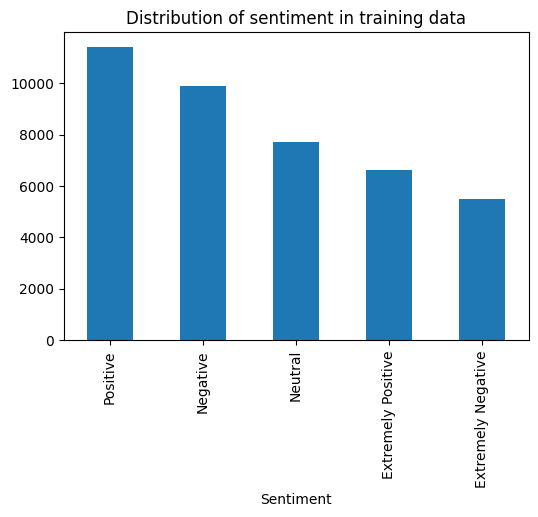

In [5]:
plt.figure(figsize = (6,4))
df_train.Sentiment.value_counts().plot(kind = 'bar')
plt.title('Distribution of sentiment in training data')

Text(0.5, 1.0, 'Distribution of sentiment in test data')

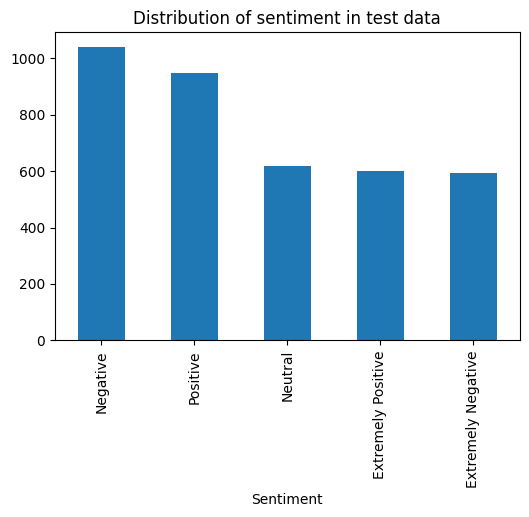

In [6]:
plt.figure(figsize = (6,4))
df_test.Sentiment.value_counts().plot(kind = 'bar')
plt.title('Distribution of sentiment in test data')

In [7]:
x = df_train['OriginalTweet']
y = df_train['Sentiment']

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow.keras.layers as layer
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [9]:
import nltk
from nltk.corpus import stopwords

In [10]:
#Cleaning the texts and getting rid of unclear symbols or characters
#This function is from: https://www.kaggle.com/code/shahraizanwar/covid19-tweets-sentiment-prediction-rnn-85-acc
import re
def text_cleaner(tweet):
    
    # remove urls
    tweet = re.sub(r'http\S+', ' ', tweet)
    
    # remove html tags
    tweet = re.sub(r'<.*?>',' ', tweet)
    
    # remove digits
    tweet = re.sub(r'\d+',' ', tweet)
    
    # remove hashtags
    tweet = re.sub(r'#\w+',' ', tweet)
    
    # remove mentions
    tweet = re.sub(r'@\w+',' ', tweet)
    
    #removing stop words
    tweet = tweet.split()
    tweet = " ".join([word for word in tweet if not word in stop_words])
    
    return tweet


stop_words = stopwords.words('english')

X_c = x.apply(text_cleaner)
X_c.head()

0                                                     
1    advice Talk neighbours family exchange phone n...
2    Coronavirus Australia: Woolworths give elderly...
3    My food stock one empty... PLEASE, panic, THER...
4    Me, ready go supermarket outbreak. Not I'm par...
Name: OriginalTweet, dtype: object

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_c)

X = tokenizer.texts_to_sequences(X_c)
vocab_size = len(tokenizer.word_index)+1

print("Vocabulary size: {}".format(vocab_size))
print("\nExample:\n")
print("Sentence:\n{}".format(X_c[8]))
print("\nAfter tokenizing :\n{}".format(X[8]))

X = pad_sequences(X, padding='post')
print("\nAfter padding :\n{}".format(X[8]))

Vocabulary size: 36117

Example:

Sentence:
Due COVID- retail store classroom Atlanta open walk-in business classes next two weeks, beginning Monday, March . We continue process online phone orders normal! Thank understanding!

After tokenizing :
[34, 1, 69, 4, 11239, 4874, 153, 665, 39, 104, 2637, 174, 172, 146, 812, 766, 186, 25, 267, 1487, 13, 802, 450, 326, 102, 2185]

After padding :
[   34     1    69     4 11239  4874   153   665    39   104  2637   174
   172   146   812   766   186    25   267  1487    13   802   450   326
   102  2185     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]


In [13]:
sentiments = {'Extremely Negative': 0,
            'Negative': 0,
            'Neutral': 1,
            'Positive':2,
            'Extremely Positive': 2
           }
y = y.map(sentiments)
labels = ['Negative', 'Neutral', 'Positive']

In [14]:
X_test = df_test['OriginalTweet'].copy()
y_test = df_test['Sentiment'].copy()

X_test = X_test.apply(text_cleaner)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, padding='post', maxlen = X.shape[1])

y_test = y_test.map(sentiments)

# Generic model

In this section, we will write a function to define a general model that takes in as the first input the type of recurrent layer (RNN, LSTM, GRU, etc.), the second input is the number of units in the recurrent layer, and the last two inputs are the number of training epochs and batch size. This function will output the trained model, the loss and accuracy of the model evaluated on the test set, and the confusion matrix.

In [15]:
def generic_model(model_layer,units, epochs, bs):
    EPOCHS = epochs
    BATCH_SIZE = bs
    embedding_dim = 16

    model= tf.keras.Sequential([
        layer.Embedding(vocab_size, embedding_dim, input_length=X.shape[1]),
        model_layer(units),
        layer.Dense(3,activation = 'softmax')
    ])
    
    model.summary()

    model.compile(loss=SparseCategoricalCrossentropy(from_logits = False),
              optimizer='adam',metrics=['accuracy']
             )
    
    history = model.fit(X, y, epochs=EPOCHS, 
                                  validation_split=0.15, batch_size=BATCH_SIZE)
    hist_model = pd.DataFrame(history.history)
    
    #Plot the loss and accuracy curves
    fig, ax = plt.subplots(2,1, figsize = (8,8))
    ax[0].plot(hist_model.loss, c = 'b')
    ax[0].plot(hist_model.val_loss, c = 'r')
    ax[0].set_title('Training and validation losses');
    ax[0].set_ylabel('Loss')
    ax[0].legend(['train', 'val'], loc='upper left')

    ax[1].plot(hist_model.accuracy, c = 'b')
    ax[1].plot(hist_model.val_accuracy, c = 'r')
    ax[1].set_title('Training and validation accuracies');
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['train', 'val'], loc='upper left')
    
    #Prediction
    pred = np.argmax(np.round(model.predict(X_test)),axis = 1)
    loss, acc = model.evaluate(X_test,y_test,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
    
                 
    #Confustion matrix
    confm = confusion_matrix(y_test, pred)
    cm= pd.DataFrame(confm, index = [i for i in labels],
                    columns = [i for i in labels])

    plt.figure(figsize = (8,6))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion Matrix')
    plt.show()
                
    return model, hist_model, loss, acc, cm

# RNN Model

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 54, 16)            577872    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 20)                740       
                                                                 
 dense_7 (Dense)             (None, 3)                 63        
                                                                 
Total params: 578,675
Trainable params: 578,675
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1094/1094 [==============================] - 71s 64ms/step - loss: 0.8829 - accuracy: 0.5984 - val_loss: 0.7764 - val_accuracy: 0.6869
Epoch 2/10
1094/1094 [==============================] - 52s 48ms/step - loss: 0.5870 - accuracy: 0.7813 - val_loss: 0.6647 - val_accuracy: 0.7506
Epoch 3/10
1094/1094

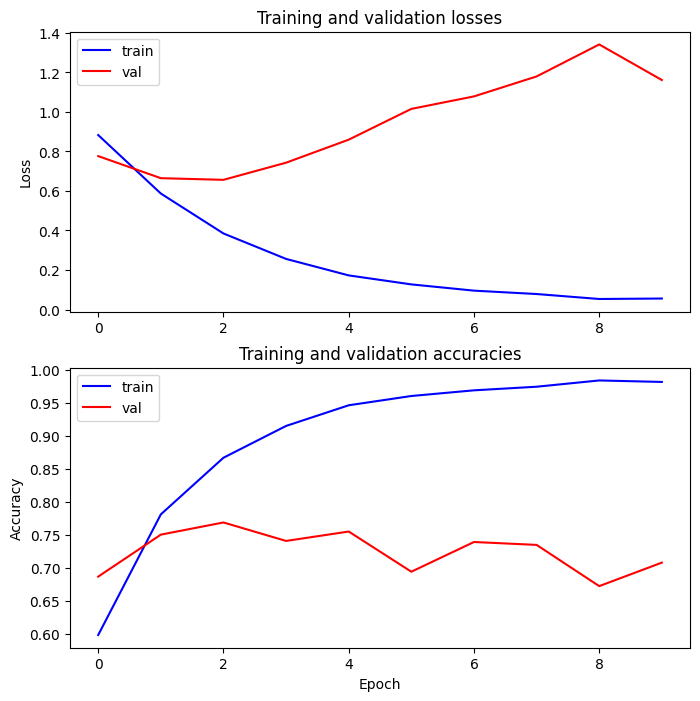

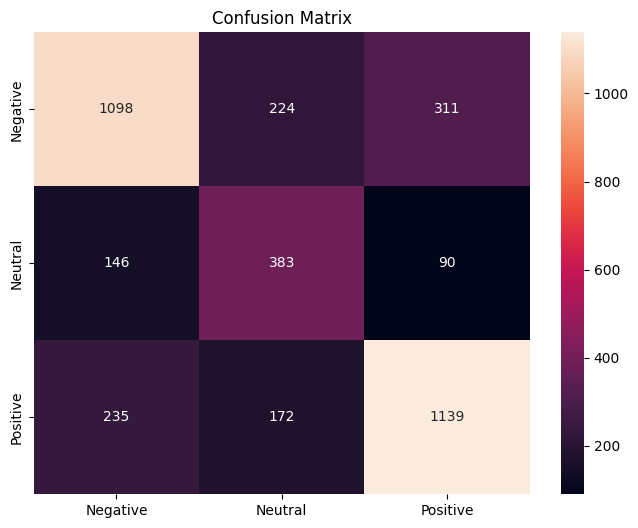

In [49]:
model_RNN = generic_model(layer.SimpleRNN, 20, 10, 32)

# LSTM Model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 54, 16)            577872    
                                                                 
 lstm_2 (LSTM)               (None, 15)                1920      
                                                                 
 dense_6 (Dense)             (None, 3)                 48        
                                                                 
Total params: 579,840
Trainable params: 579,840
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
1094/1094 [==============================] - 29s 25ms/step - loss: 0.9491 - accuracy: 0.4994 - val_loss: 0.7520 - val_accuracy: 0.6613
Epoch 2/8
1094/1094 [==============================] - 9s 8ms/step - loss: 0.5774 - accuracy: 0.7875 - val_loss: 0.5513 - val_accuracy: 0.8077
Epoch 3/8
1094/1094 [===

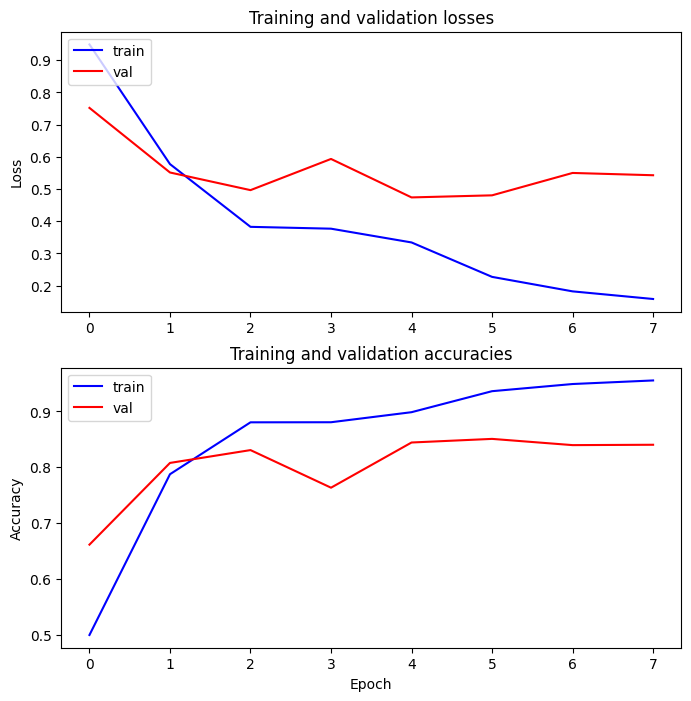

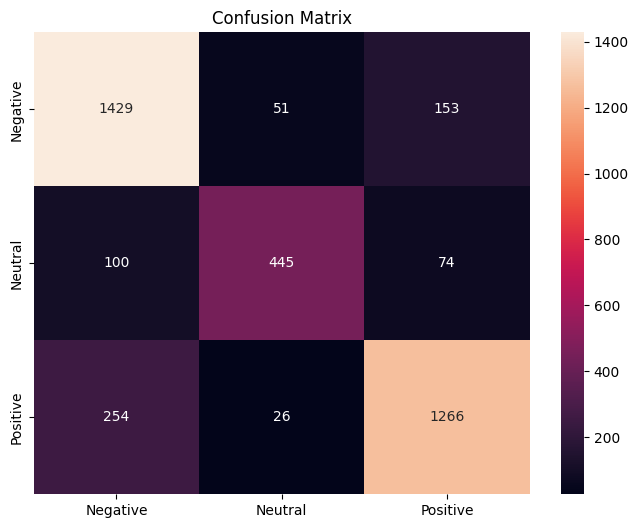

In [48]:
model_LSTM = generic_model(layer.LSTM,15, 8, 32)

# GRU Model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 54, 16)            577872    
                                                                 
 gru (GRU)                   (None, 15)                1485      
                                                                 
 dense_2 (Dense)             (None, 3)                 48        
                                                                 
Total params: 579,405
Trainable params: 579,405
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
1094/1094 [==============================] - 30s 26ms/step - loss: 1.0435 - accuracy: 0.4327 - val_loss: 1.0489 - val_accuracy: 0.4606
Epoch 2/6
1094/1094 [==============================] - 8s 7ms/step - loss: 1.0426 - accuracy: 0.4346 - val_loss: 1.0506 - val_accuracy: 0.4606
Epoch 3/6
1094/1094 [===

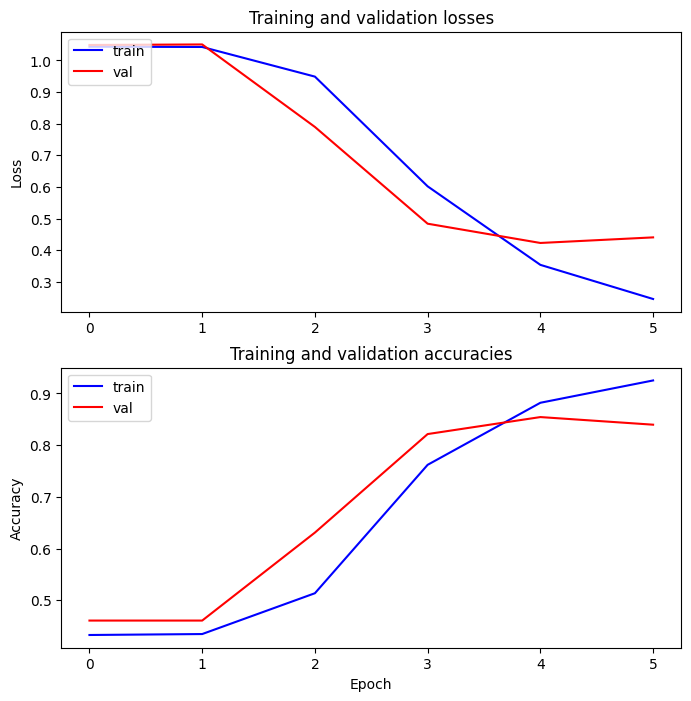

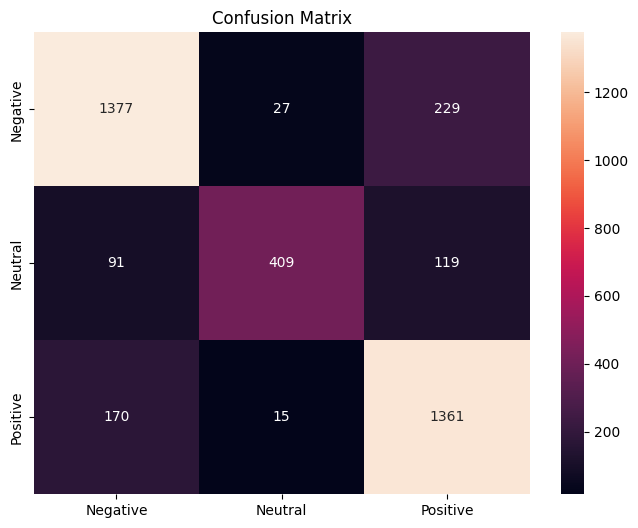

In [18]:
model_GRU = generic_model(layer.GRU,15, 6, 32)

# General model with pretrained GloVe Embedding 

In this section, we define a general model that can take in as inputs any type of recurrent layers, but with an added pretrained GloVe Embedding layer. This function also allows for the flexibility of adding a Bidirectional wrapper for the recurrent layer. 

In [23]:
EMBEDDING_FILE = '/kaggle/input/glove-twitter/glove.twitter.27B.100d.txt'

In [36]:
#EMBEDDING_DIM must equal the number ###d.txt
EMBEDDING_DIM = 100
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

In [37]:
#Checking the number of word vectors
embeddings_index = {}

f = open(EMBEDDING_FILE)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 1193514 word vectors.


In [40]:
#Define the entries of the embedding matrix 
#which serve as weights of the Embedding layer
word_index = tokenizer.word_index
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
embedding_matrix.shape

for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector

In [41]:
#Define the embedding layer for the neural network
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=X.shape[1],
                                          trainable=False)

In [55]:
def generic_model_pretrained_embedding(model_layer, units, epochs, bs, bidir=False):
#This function allows for a Bidirectional wrapper if the parameter bidir = True
    EPOCHS = epochs
    BATCH_SIZE = bs
    
    sequence_input = layer.Input(shape=(X.shape[1],),)
    embedding_sequences = embedding_layer(sequence_input)
    x = layer.SpatialDropout1D(0.2)(embedding_sequences)
    x = layer.Conv1D(32, 5, activation='relu')(x)
    if bidir:
        x = layer.Bidirectional(model_layer(units))(x)
    else:
        x = model_layer(units)(x)
    outputs = layer.Dense(3, activation='softmax')(x)
    model = tf.keras.Model(sequence_input, outputs)
    model.summary()

    model.compile(loss=SparseCategoricalCrossentropy(from_logits = False),
              optimizer='adam',metrics=['accuracy'])
    
    history = model.fit(X, y, epochs=EPOCHS, 
                                  validation_split=0.15, batch_size=BATCH_SIZE)
    hist_model = pd.DataFrame(history.history)
    
    
    #Plot the loss and accuracy curves
    fig, ax = plt.subplots(2,1, figsize = (8,8))
    ax[0].plot(hist_model.loss, c = 'b')
    ax[0].plot(hist_model.val_loss, c = 'r')
    ax[0].set_title('Training and validation losses');
    ax[0].set_ylabel('Loss')
    ax[0].legend(['train', 'val'], loc='upper left')

    ax[1].plot(hist_model.accuracy, c = 'b')
    ax[1].plot(hist_model.val_accuracy, c = 'r')
    ax[1].set_title('Training and validation accuracies');
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['train', 'val'], loc='upper left')
    
    #Prediction
    pred = np.argmax(np.round(model.predict(X_test)),axis = 1)
    loss, acc = model.evaluate(X_test,y_test,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
    
                 
    #Confustion matrix
    confm = confusion_matrix(y_test, pred)
    cm= pd.DataFrame(confm, index = [i for i in labels],
                    columns = [i for i in labels])

    plt.figure(figsize = (8,6))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion Matrix')
    plt.show()
                
    return model, hist_model, loss, acc, cm

# RNN Model with GloVe

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 54)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 54, 100)           3611700   
                                                                 
 spatial_dropout1d_6 (Spatia  (None, 54, 100)          0         
 lDropout1D)                                                     
                                                                 
 conv1d_6 (Conv1D)           (None, 50, 32)            16032     
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 20)                1060      
                                                                 
 dense_11 (Dense)            (None, 3)                 63        
                                                           

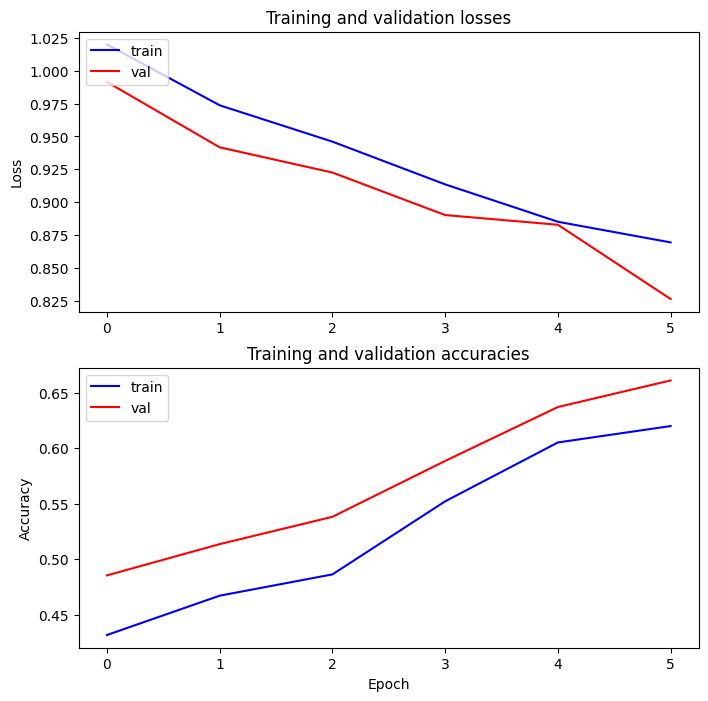

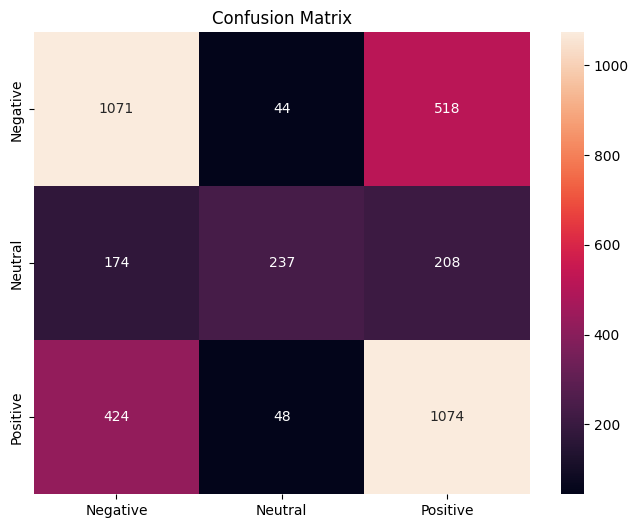

In [56]:
model_RNN_G = generic_model_pretrained_embedding(layer.SimpleRNN, 20, 6, 32)

# LSTM Model with GloVe

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 54)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 54, 100)           3611700   
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 54, 100)          0         
 lDropout1D)                                                     
                                                                 
 conv1d_4 (Conv1D)           (None, 50, 32)            16032     
                                                                 
 lstm_3 (LSTM)               (None, 15)                2880      
                                                                 
 dense_9 (Dense)             (None, 3)                 48        
                                                           

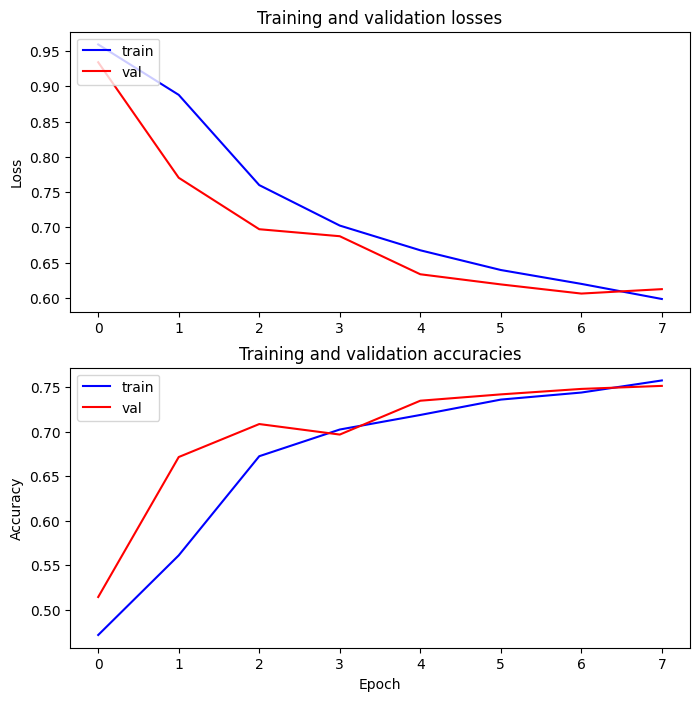

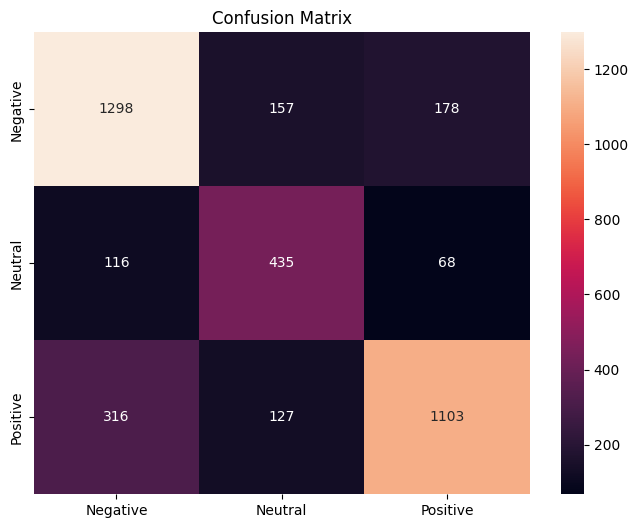

In [51]:
model_LSTM_G = generic_model_pretrained_embedding(layer.LSTM, 15, 8, 32)

# GRU Model with GloVe

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 54)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 54, 100)           3611700   
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 54, 100)          0         
 lDropout1D)                                                     
                                                                 
 conv1d_5 (Conv1D)           (None, 50, 32)            16032     
                                                                 
 gru_2 (GRU)                 (None, 15)                2205      
                                                                 
 dense_10 (Dense)            (None, 3)                 48        
                                                           

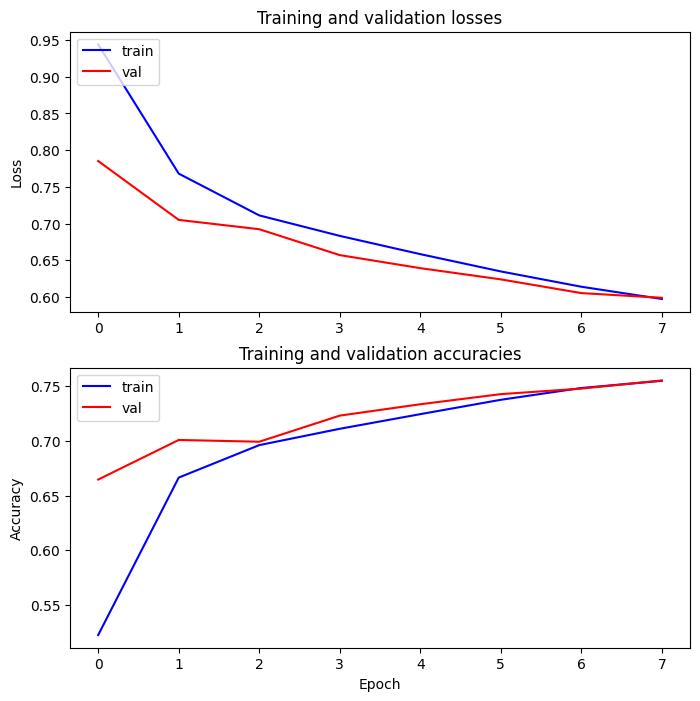

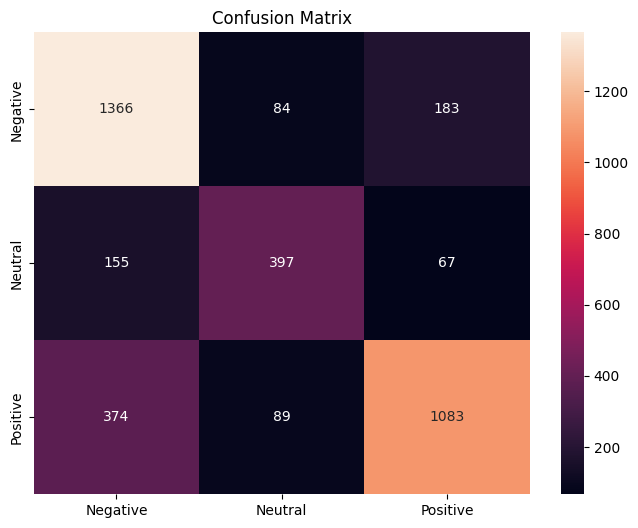

In [52]:
model_GRU_G = generic_model_pretrained_embedding(layer.GRU, 15, 8, 32)

# Bidirectional LSTM with GloVe

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 54)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 54, 100)           3611700   
                                                                 
 spatial_dropout1d_7 (Spatia  (None, 54, 100)          0         
 lDropout1D)                                                     
                                                                 
 conv1d_7 (Conv1D)           (None, 50, 32)            16032     
                                                                 
 bidirectional (Bidirectiona  (None, 30)               5760      
 l)                                                              
                                                                 
 dense_12 (Dense)            (None, 3)                 93  

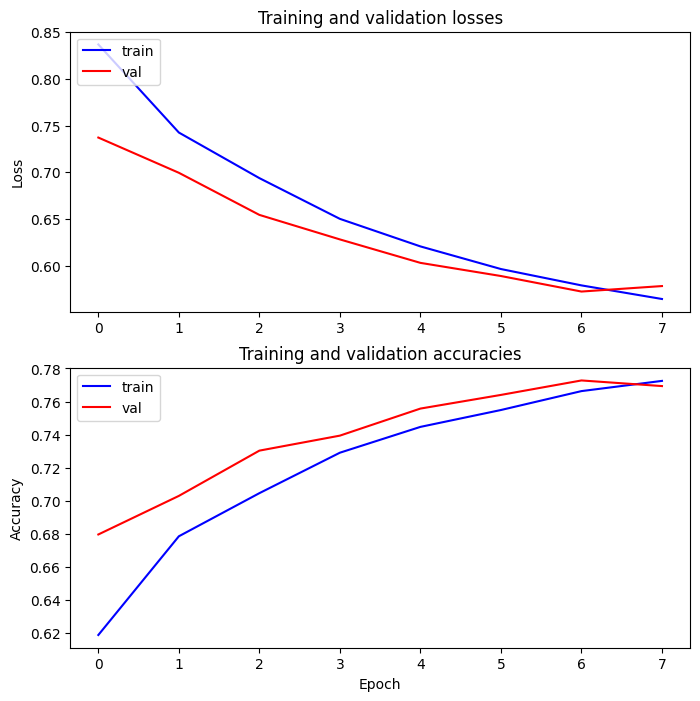

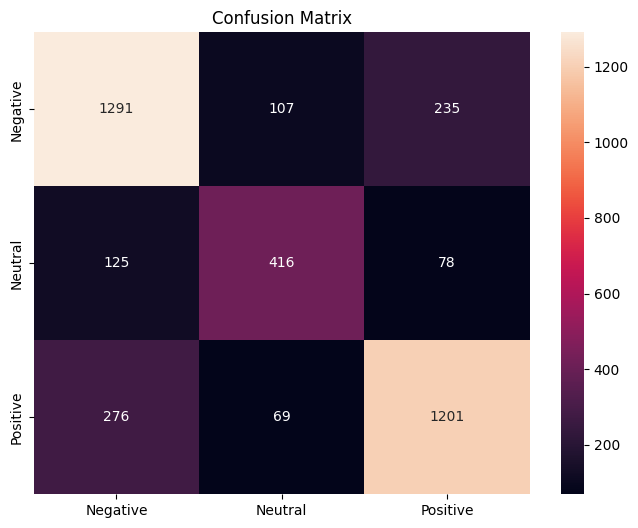

In [58]:
model_bLSTM_G = generic_model_pretrained_embedding(layer.LSTM, 15, 8, 32,bidir = True)